<a href="https://colab.research.google.com/github/Babji-Gandi/Image-Reconstruction/blob/master/runtime_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
!git clone https://github.com/jyhmiinlin/pynufft.git

Cloning into 'pynufft'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 2914 (delta 11), reused 13 (delta 7), pack-reused 2888
Receiving objects: 100% (2914/2914), 35.37 MiB | 18.85 MiB/s, done.
Resolving deltas: 100% (1848/1848), done.


In [3]:

!cp -r /content/drive/My\Drive/thesis/gpu.py /content/pynufft/tests

cp: cannot stat '/content/drive/MyDrive/thesis/gpu.py': No such file or directory


In [4]:
!pip install pynufft


     |████████████████████████████████| 16.2MB 216kB/s 


In [5]:
!pip install reikna

     |████████████████████████████████| 194kB 12.4MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
  Created wheel for reikna: filename=reikna-0.7.5-cp36-none-any.whl size=122267 sha256=ad74131b9ca76902f08174e256637f5c1be2a6f3549d292b4d51b832dffba780
  Stored in directory: /root/.cache/pip/wheels/82/2d/ba/12c9ba3637183463c471bcf352f5bc1703ab7dfbec9842f04a
Successfully built reikna


In [6]:

!pip install pycuda

     |████████████████████████████████| 1.6MB 13.2MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621033 sha256=0d5ba9d8d9b64c92cb6960d69a7955a64639040686290ba839c58871fd578ac7
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2021.1-py2.py3-none-any.whl size=60415 sha256=491879a745bfd6d871afbaca64fd66286ee514d4ba92efb28739ee3e1ae5e5bf
  Stored in directory: /root/.cache/pip/wheels/5d/85/10/7da05d77b47f2cb503e5c4185ba82187d0b6b6736b3c6641e0
Successfully built pycuda pytools


In [7]:
!pip install pyopencl

     |████████████████████████████████| 747kB 12.6MB/s 


In [8]:
!pip install scipy

In [9]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
!pip install queuelib

In [11]:
import time
from pynufft import NUFFT, helper
import pynufft
import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import argparse as args
import pycuda
import pycuda.autoinit
dtype = numpy.complex64
import pkg_resources
import scipy
import scipy.misc

In [12]:
def image_dimension_speed_test(A, dim_1, dim_2, plot_name, color_label):
    dim_speed = []
    om = numpy.random.randn(10, 2)
    for i in range(len(dim_1)):
        for j in range(len(dim_2)):
            for l in range(101):
                Nd = dim_1[i]
                Kd = dim_2[j]
                Jd = (4, 4)
                A.plan(om, Nd, Kd, Jd)
                x = numpy.random.randn(*Nd)
                gx = A.to_device(x)
                startTime = time.time()
                gy = A._forward_device(gx)
                executionTime = (time.time() - startTime)
                if l!=0:
                  dim_speed.append(executionTime)
            std_dev_dim = numpy.std(dim_speed)
            average_speed = sum(dim_speed) / len(dim_speed)
            if i == (len(dim_1) - 1):
                plot_name.errorbar(Nd[0], average_speed, yerr=std_dev_dim, color=f'{color_label[j]}', fmt='-o',
                                   label=f'k_dim = {Kd[0]}, Jd = {Jd[0]}')
            else:
                plot_name.errorbar(Nd[0], average_speed, yerr=std_dev_dim, color=f'{color_label[j]}', fmt='-o')
            print(f'execution time is {average_speed} seconds when Nd = {Nd} and Kd = {Kd} and Jd = {Jd}')
            dim_speed.clear()
    return plot_name


def kd_speed_test(A, dim_1, dim_2, plot_name, color_label):
    dim_speed = []
    om = numpy.random.randn(10, 2)
    for i in range(len(dim_1)):
        for j in range(len(dim_2)):
            for l in range(101):
                Kd = dim_1[i]
                Nd = dim_2[j]
                Jd = (4, 4)
                A.plan(om, Nd, Kd, Jd)
                x = numpy.random.randn(*Nd)
                gx = A.to_device(x)
                startTime = time.time()
                gy = A._forward_device(gx)
                executionTime = (time.time() - startTime)
                if l!=0:
                  dim_speed.append(executionTime)
            std_dev_dim = numpy.std(dim_speed)
            average_speed = sum(dim_speed) / len(dim_speed)
            if i == (len(dim_1) - 1):
                plot_name.errorbar(Kd[0], average_speed, yerr=std_dev_dim, color=f'{color_label[j]}', fmt='-o',
                                   label=f'N_dim = {Nd[0]}, Jd = {Jd[0]}')
            else:
                plot_name.errorbar(Kd[0], average_speed, yerr=std_dev_dim, color=f'{color_label[j]}', fmt='-o')
            print(f'execution time is {average_speed} seconds when Kd = {dim_1[i]} and Nd = {dim_2[j]} and '
                  f'Jd = {Jd}')
            dim_speed.clear()
    return plot_name


def jd_speed_test(A, dim_1, dim_2, plot_name, color_label):
    dim_speed = []
    om = numpy.random.randn(10, 2)
    for i in range(len(dim_1)):
        for j in range(len(dim_2)):
            for l in range(101):
                Jd = dim_1[i]
                Nd = (128, 128)
                Kd = dim_2[j]
                A.plan(om, Nd, Kd, Jd)
                x = numpy.random.randn(*Nd)
                gx = A.to_device(x)
                startTime = time.time()
                gy = A._forward_device(gx)
                executionTime = (time.time() - startTime)
                if l!=0:
                  dim_speed.append(executionTime)
            std_dev_dim = numpy.std(dim_speed)
            average_speed = sum(dim_speed) / len(dim_speed)
            if i == (len(dim_1) - 1):
                plot_name.errorbar(Jd[0], average_speed, yerr=std_dev_dim, color=f'{color_label[j]}', fmt='-o',
                                       label=f'N_dim = {Nd[0]}, Kd = {Kd[0]}')
            else:
                plot_name.errorbar(Jd[0], average_speed, yerr=std_dev_dim, color=f'{color_label[j]}', fmt='-o')
            print(f'execution time is {average_speed} seconds when Jd = {dim_1[i]} and Nd = {Nd} and '
                  f'Kd = {dim_2[j]}')
            dim_speed.clear()
    return plot_name


In [13]:
img_dimensions = [(64, 64), (128, 128), (256, 256), (512, 512)]
#750
color = ['red', 'green', 'yellow', 'blue', 'orange']
k_d = [(128, 128), (256, 256), (512, 512), (1024, 1024), (2048, 2048)]
#1024 1500
j_d = [(2, 2), (3, 3), (4, 4), (5, 5), (6, 6)]

In [14]:
'''img_dimensions = [(64, 64)] #, (128, 128),(256, 256), (512, 512)]
#750
color = ['red'] #, 'green', 'yellow', 'blue']#, 'orange']
k_d = [(2048, 2048)] #, (256, 256)], (512, 512), (1024, 1024), (2048, 2048)]
#1024 1500
j_d = [(4, 4)] #, (3, 3)]#, (4, 4), (5, 5), (6, 6)]'''

"img_dimensions = [(64, 64)] #, (128, 128),(256, 256), (512, 512)]\n#750\ncolor = ['red'] #, 'green', 'yellow', 'blue']#, 'orange']\nk_d = [(2048, 2048)] #, (256, 256)], (512, 512), (1024, 1024), (2048, 2048)]\n#1024 1500\nj_d = [(4, 4)] #, (3, 3)]#, (4, 4), (5, 5), (6, 6)]"

In [15]:
'''dim_speed = []
om = numpy.random.randn(10, 2)
A = NUFFT(helper.device_list()[0])
Nd = (64, 64)
Kd = (128, 128)
Jd = (4, 4)
A.plan(om, Nd, Kd, Jd)
x = numpy.random.randn(*Nd)
gx = A.to_device(x)
for l in range(101):
    startTime = time.time()
    gy = A._forward_device(gx)
    executionTime = (time.time() - startTime)
    #print(executionTime)
    if l!=0:
      dim_speed.append(executionTime)

fig1,(ax4)=plt.subplots(1, 1,figsize=(15,10))
ax4.hist(dim_speed)'''

'dim_speed = []\nom = numpy.random.randn(10, 2)\nA = NUFFT(helper.device_list()[0])\nNd = (64, 64)\nKd = (128, 128)\nJd = (4, 4)\nA.plan(om, Nd, Kd, Jd)\nx = numpy.random.randn(*Nd)\ngx = A.to_device(x)\nfor l in range(101):\n    startTime = time.time()\n    gy = A._forward_device(gx)\n    executionTime = (time.time() - startTime)\n    #print(executionTime)\n    if l!=0:\n      dim_speed.append(executionTime)\n\nfig1,(ax4)=plt.subplots(1, 1,figsize=(15,10))\nax4.hist(dim_speed)'

execution time is 0.0009498095512390137 seconds when Nd = (64, 64) and Kd = (128, 128) and Jd = (4, 4)
execution time is 0.0009613776206970215 seconds when Nd = (64, 64) and Kd = (256, 256) and Jd = (4, 4)
execution time is 0.001367981433868408 seconds when Nd = (64, 64) and Kd = (512, 512) and Jd = (4, 4)
execution time is 0.0015215110778808594 seconds when Nd = (64, 64) and Kd = (1024, 1024) and Jd = (4, 4)
execution time is 0.001993858814239502 seconds when Nd = (64, 64) and Kd = (2048, 2048) and Jd = (4, 4)
execution time is 0.0009851956367492676 seconds when Nd = (128, 128) and Kd = (128, 128) and Jd = (4, 4)
execution time is 0.0009885835647583008 seconds when Nd = (128, 128) and Kd = (256, 256) and Jd = (4, 4)
execution time is 0.0013835930824279785 seconds when Nd = (128, 128) and Kd = (512, 512) and Jd = (4, 4)
execution time is 0.0015334177017211914 seconds when Nd = (128, 128) and Kd = (1024, 1024) and Jd = (4, 4)
execution time is 0.002002272605895996 seconds when Nd = (128

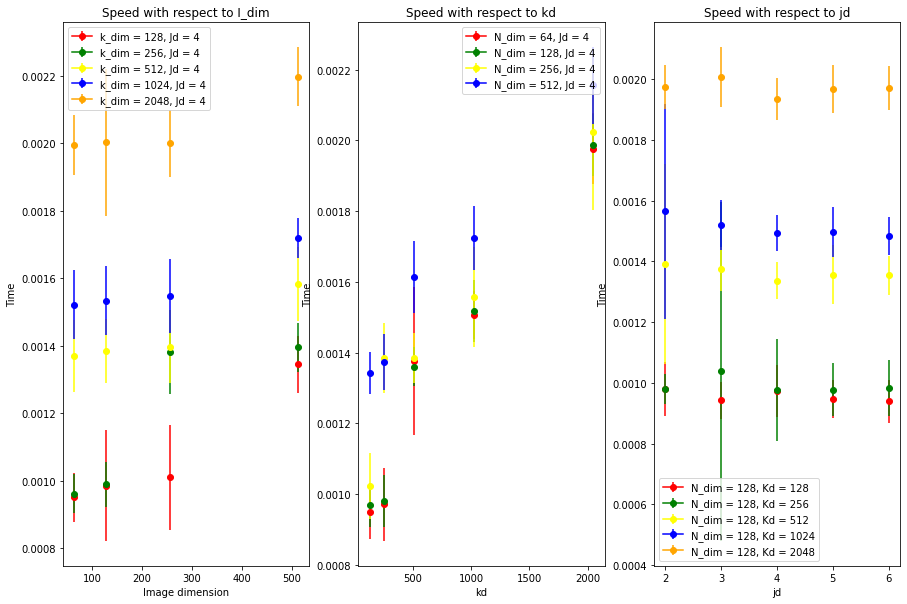

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,10))
nufft_obj = NUFFT(helper.device_list()[0])
ax1 = image_dimension_speed_test(nufft_obj, img_dimensions, k_d, ax1, color)
ax1.legend(loc="upper left")
ax1.set_title('Speed with respect to I_dim')
ax1.set_xlabel('Image dimension')
ax1.set_ylabel('Time')

ax2 = kd_speed_test(nufft_obj, k_d, img_dimensions, ax2, color)
ax2.legend(loc="upper right")
ax2.set_title('Speed with respect to kd')
ax2.set_xlabel('kd')
ax2.set_ylabel('Time')

ax3 = jd_speed_test(nufft_obj, j_d, k_d, ax3, color)
ax3.legend(loc="upper right")
ax3.set_title('Speed with respect to jd')
ax3.set_xlabel('jd')
ax3.set_ylabel('Time')
plt.savefig('/content/pynufft/tests/test.png')
plt.legend()
plt.show()
